# Setup

In [27]:
#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
import seaborn as sns
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import cv2 as cv
import math
import os
#import tensorflow.keras.metrics
#from keras import ops

# Dataset loading

## Separation and resizing of pictures

In [2]:
# Loads all dataset present in Train folder
def load_datasets(folder_path):
    full_da = None
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv') :
            if full_da is None:
                full_da = np.loadtxt(f'{folder_path}{filename}', dtype = "int32", delimiter=',')
            else:
                da = np.loadtxt(f'{folder_path}{filename}', dtype = "int32", delimiter=',')
                full_da = np.append(full_da, da, axis = 0)
        else:
            continue
    return full_da

In [3]:
# Loads all dataset present in Train folder
full_da = load_datasets("data_resultsheets/Train/")
print(full_da.shape)
print(full_da)
test_da = load_datasets("data_resultsheets/Test/")
print(test_da.shape)
print(test_da)

(5131, 6233)
[[255 255 255 ... 255 255   1]
 [255 255 255 ... 255 255   1]
 [255 255 255 ... 255 255   1]
 ...
 [255 255 255 ... 255 255   9]
 [255 255 255 ... 255 255   9]
 [255 255 255 ... 255 255   9]]
(764, 6233)
[[255 255 255 ... 255 255   6]
 [255 255 254 ... 255 255   3]
 [255 255 254 ... 255 255   7]
 ...
 [246 244 244 ... 251 248   0]
 [251 252 252 ... 249 250   0]
 [244 246 243 ... 251 251   0]]


In [4]:
# Plotting mean pixel intensity in function of label.
def plot_mpi(full_da):
    mean_pix = full_da[:, :-1].mean(axis=1)
    labels = full_da[:, -1]
    jitter = np.random.normal(0, 0.1, size=len(labels))
    plt.plot(labels + jitter, mean_pix, 'o')
    plt.xlabel('Labels')
    plt.ylabel('Moyenne')
    plt.show()

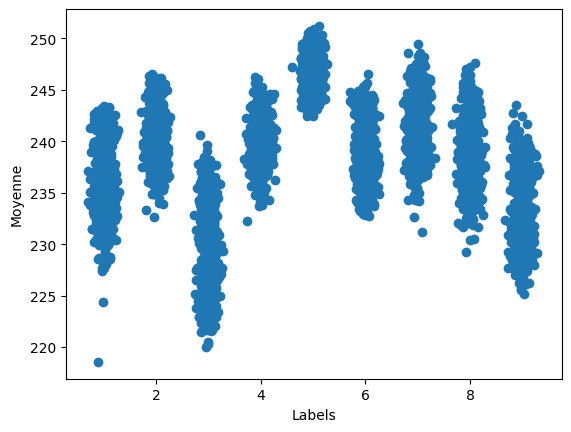

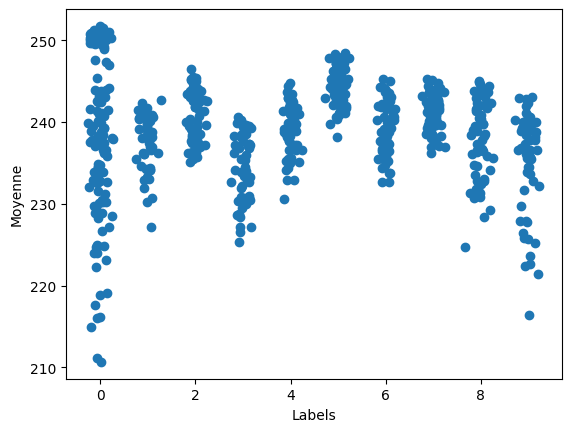

In [5]:
plot_mpi(full_da)
plot_mpi(test_da)

In [6]:
# Separation of images and labels
def split_img_label(full_da, ext_w=76, ext_h=82):
    pict, label = np.split(full_da, [ext_w*ext_h], axis = 1)
    pict = pict.reshape((len(pict), ext_w, ext_h))
    return (pict, label)

In [7]:
# Separation of images and labels
pict, label = split_img_label(full_da)
print(pict.shape)
print(label.shape)
# Supprimer les lignes où le label est égal à 0
keeper_i_test = np.where(test_da[:, -1] != 0)[0]
test_da_f = test_da[keeper_i_test, :]
pict_t, label_t = split_img_label(test_da_f)
print(pict_t.shape)
print(label_t.shape)

(5131, 76, 82)
(5131, 1)
(559, 76, 82)
(559, 1)


In [8]:
# Redimension pictures
def redimension_pict(pict_array, new_size):
    pict_array = pict_array.astype(np.float32)
    pict_array = pict_array.reshape(-1, pict_array.shape[1], pict_array.shape[2], 1)
    pict_array_redim = np.empty((len(pict_array), new_size[0], new_size[1]))
    # Boucle sur chaque image de l'array
    for i in range(len(pict_array)):
        img_resized = cv.resize(pict_array[i], new_size, interpolation=cv.INTER_AREA)
        pict_array_redim[i] = img_resized
    print(pict_array_redim.shape)
    return pict_array_redim

In [9]:
# Redimension pictures
size = (28, 28)
pict_redim = redimension_pict(pict, size)
pict_t_redim = redimension_pict(pict_t, size)

(5131, 28, 28)
(559, 28, 28)


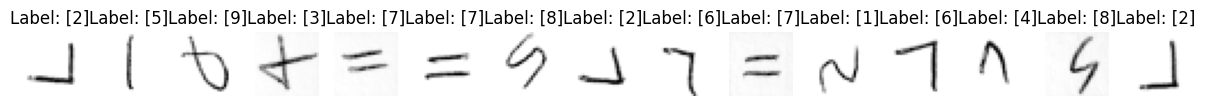

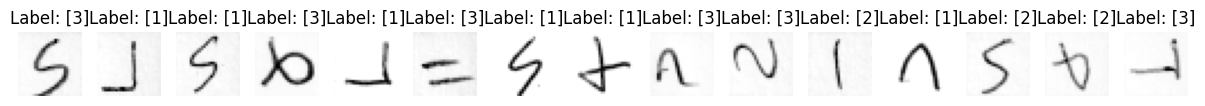

In [10]:
# Define a function to visualize samples from the dataset
def visualize_random_samples(X, y, num_samples=5):
    # Obtain a subset of random indices
    sample_indices = np.random.choice(len(X), num_samples, replace=False)

    # Create a grid plot for the samples
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 3))
    for i, idx in enumerate(sample_indices):
        # Reshape and display each sample as an image
        axes[i].imshow(X[idx], cmap='gray')
        # Set the title for each subplot as the corresponding label
        axes[i].set_title(f"Label: {y[idx]}")
        # Hide axis ticks for a cleaner look
        axes[i].axis('off')
    # Adjust layout for better spacing between subplots
    plt.tight_layout()
    # Display the plot
    plt.show()

# Call the function to visualize 10 random samples from the dataset
visualize_random_samples(pict_redim, label, num_samples=15)
visualize_random_samples(pict_t_redim, label, num_samples=15)



In [11]:
# Function to visualize all symbols corresponding to certain labels
def visualize_symbols(images, labels, imgperrow = 12):
    for l in np.unique(labels):
        label_mask = (labels == l)
        img_indices = np.where(label_mask)[0]

        n_rows = math.ceil(len(images[img_indices]) / imgperrow)
        fig, axs = plt.subplots(n_rows, imgperrow, figsize=(imgperrow, n_rows))

        for i, pixels in enumerate(images[img_indices]):
            row = i // imgperrow
            col = i % imgperrow
            ax = axs[row, col]
            ax.imshow(pixels, cmap = 'gray')
            ax.text(0.5, 1.02, str(img_indices[i]), transform=ax.transAxes, ha='center', va='bottom', fontsize=10)
            ax.axis('off')
        fig.suptitle(f'Label {l}', fontsize=16)
        fig.subplots_adjust(top=0.75)
        plt.show()

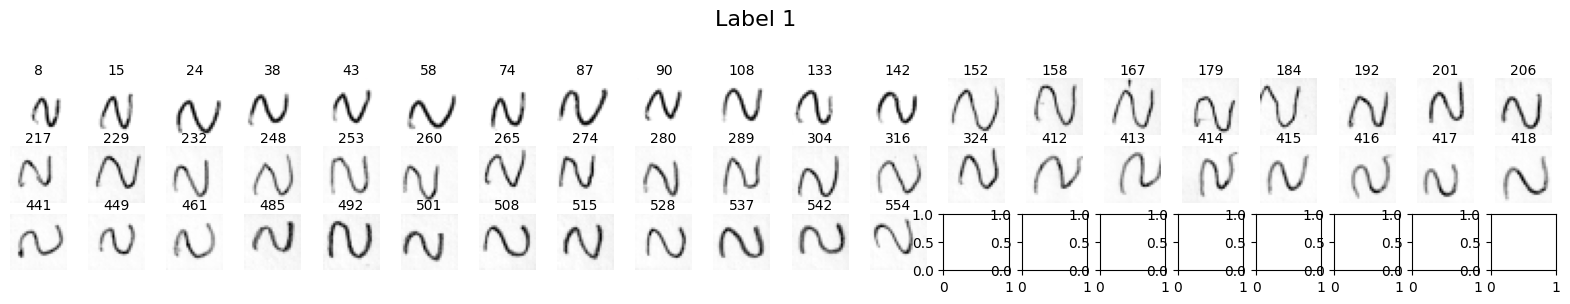

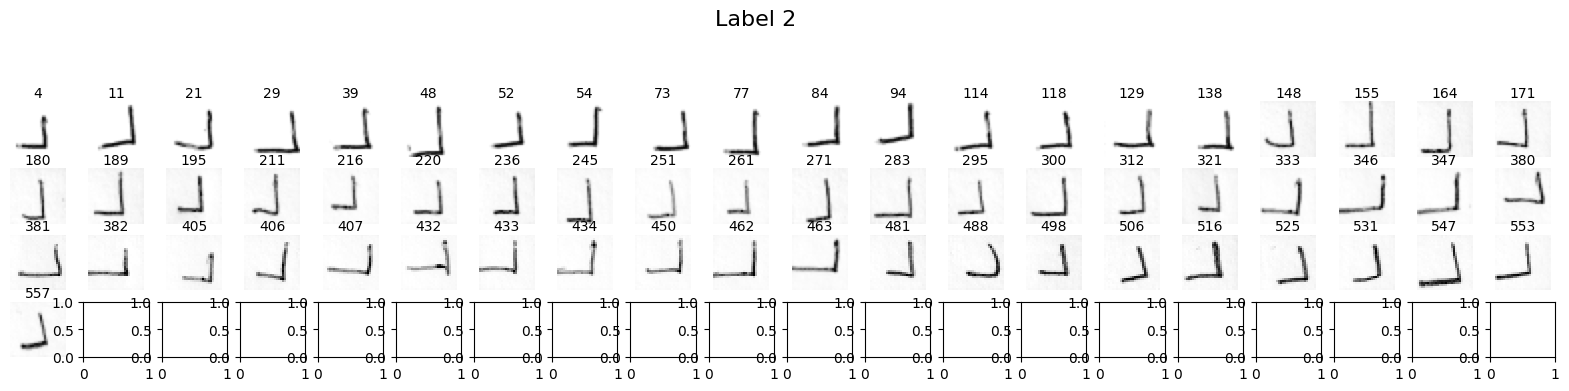

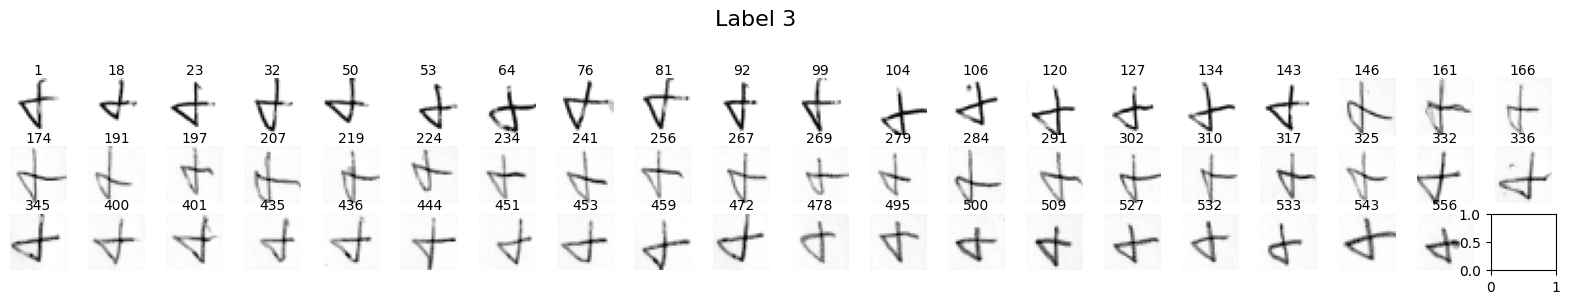

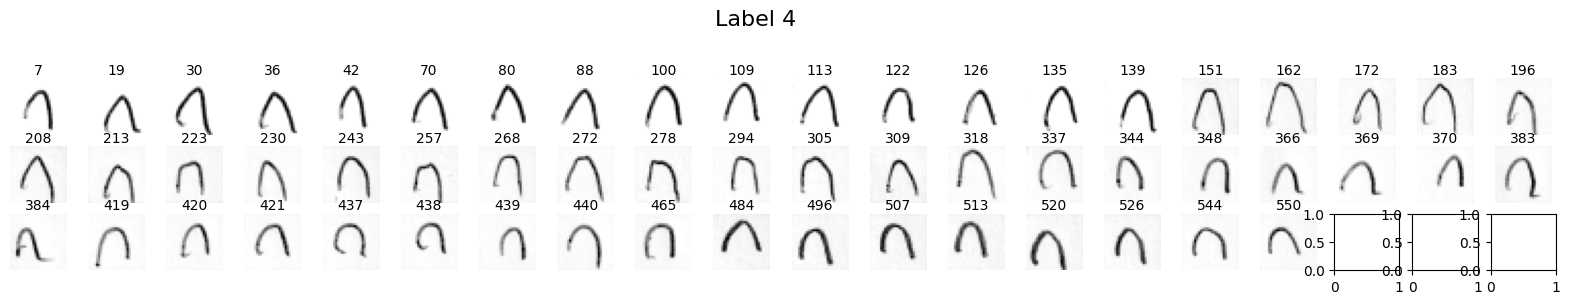

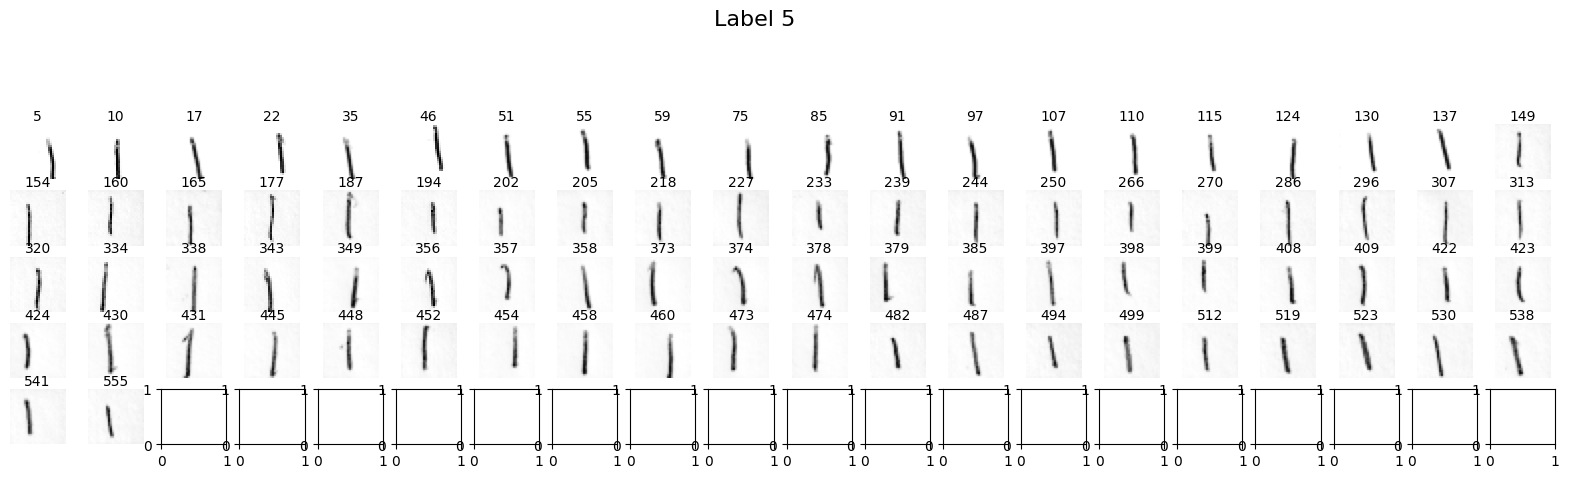

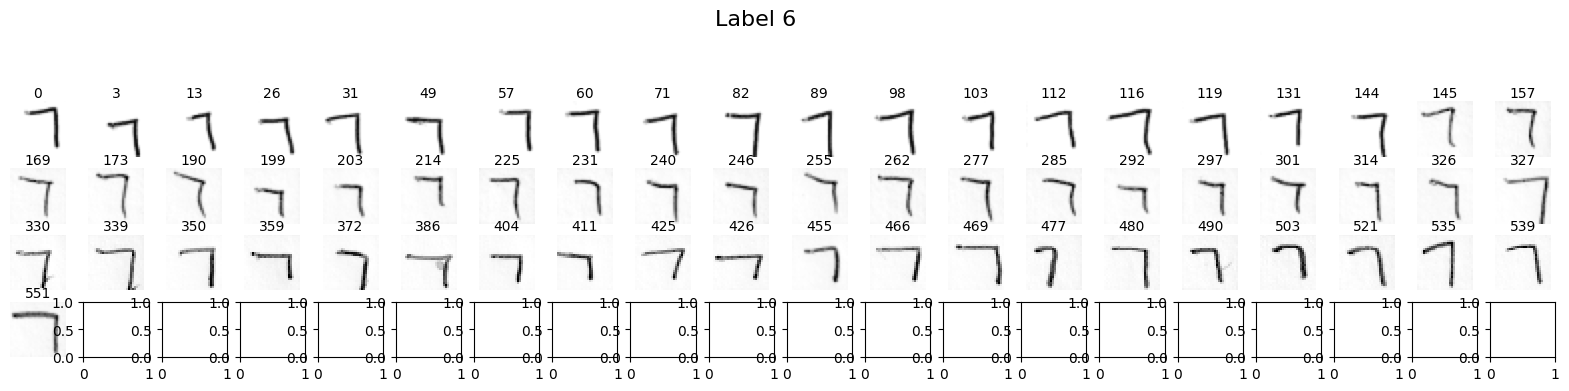

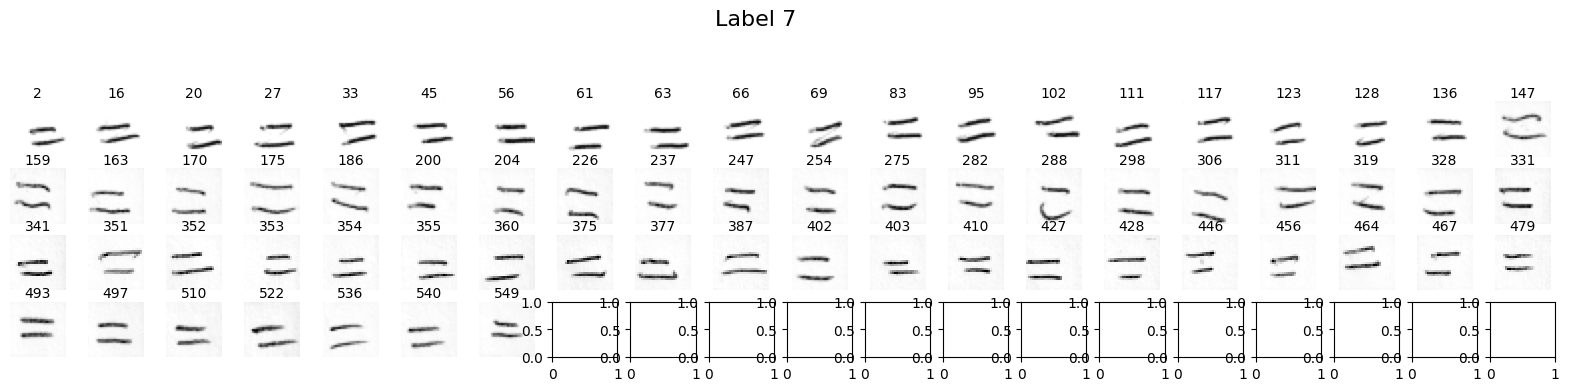

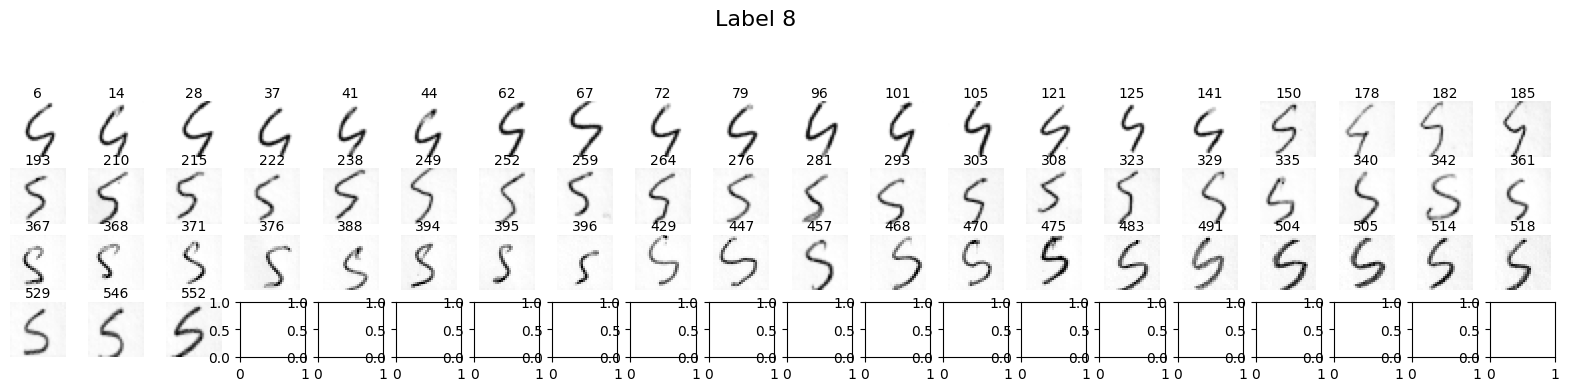

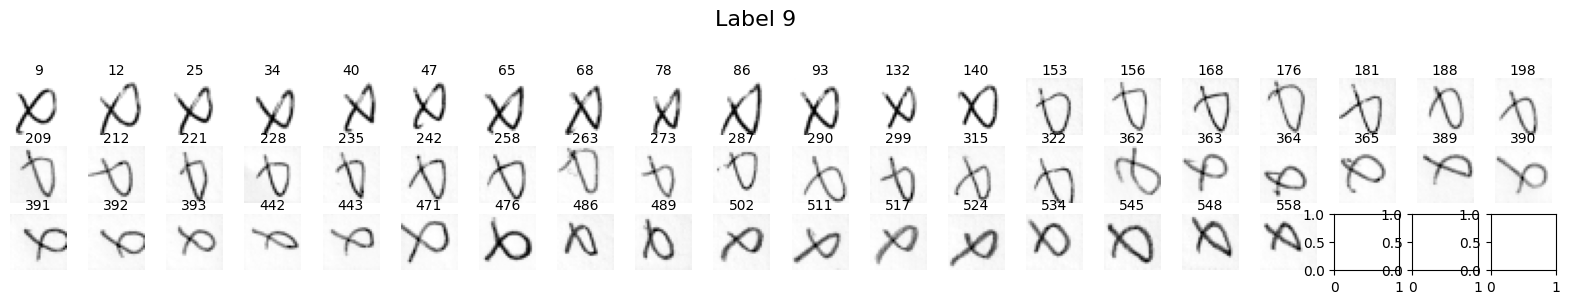

In [12]:
visualize_symbols(images=pict_t_redim, labels=label_t, imgperrow = 20)

## Normalisation and Train-test split

In [13]:
# Normalize the pixel values of the images to be between 0 and 1
pict_n = pict_redim / 255
pict_t_n = pict_t_redim / 255


In [16]:
all_pict = np.vstack((pict_n, pict_t_n))
print(all_pict.shape)

(5690, 28, 28)


In [17]:
# Split the DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pict_n, label, test_size=0.2, random_state=42)

In [38]:
#X_train = pict_n
#X_test = pict_t_n
#y_train = label
#y_test = label_t

Training DataArray :
(4104, 28, 28)
(4104, 1)
Test DataArray :
(1027, 28, 28)
(1027, 1)


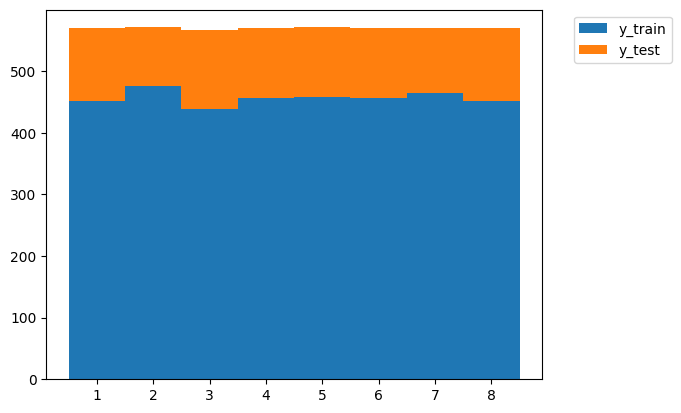

In [18]:
# Display the first five rows of the training DataFrame
print("Training DataArray :")
print(X_train.shape)
print(y_train.shape)

# Display the first five rows of the test DataFrame
print("Test DataArray :")
print(X_test.shape)
print(y_test.shape)
plt.hist([y_train.flatten(), y_test.flatten()], bins=np.arange(0.5, 9.5, 1), stacked=True, label=['y_train', 'y_test'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Training of the model

In [19]:
def get_model_dnn(shape):
    model = keras.Sequential(name = 'dnn')
    model.add(keras.layers.Input(shape, name='InputLayer'))
    model.add(keras.layers.Flatten(name='FlattenImg'))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n1'))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
    model.add(keras.layers.Dense(9, activation='softmax', name='Output'))
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="acc"),
    ],)
    return model

In [20]:
model = get_model_dnn(size)
model.summary()

Model: "dnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ FlattenImg (Flatten)                 │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_n1 (Dense)                     │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_n2 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,985 (214.79 KB)

 Trainable params: 54,985 (214.79 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
batch_size = 64
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="models/DNNmodel_at_epoch_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
]

history = model.fit(
    X_train,
    y_train-1,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test-1),
    callbacks=callbacks,
)


Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - acc: 0.1655 - loss: 2.1981 - val_acc: 0.3252 - val_loss: 1.9310
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.4119 - loss: 1.8307 - val_acc: 0.4985 - val_loss: 1.5667
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.5694 - loss: 1.5066 - val_acc: 0.6339 - val_loss: 1.2760
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.6566 - loss: 1.2208 - val_acc: 0.6962 - val_loss: 1.0714
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.6999 - loss: 1.0414 - val_acc: 0.7020 - val_loss: 0.9939
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7301 - loss: 0.9566 - val_acc: 0.7468 - val_loss: 0.8987
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7470 - loss: 0.8539 - val_acc: 0.8033 - val_loss: 0.7460
Epoch 8/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7841 - loss: 0.7710 - val_acc: 0.7702 - val_loss: 0.7912
Epoch 9/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7965 - loss:

In [22]:
score

[0.4195675253868103, 0.8958130478858948]

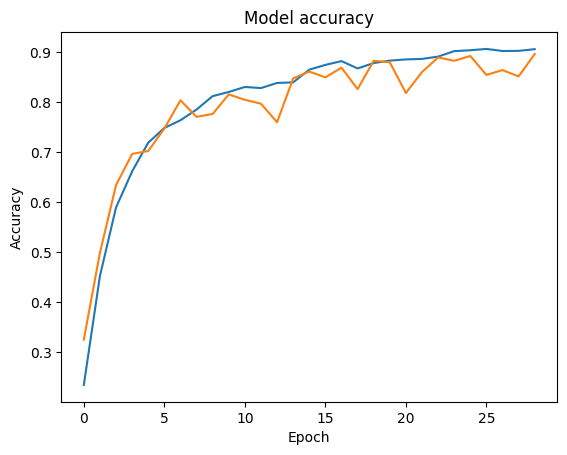

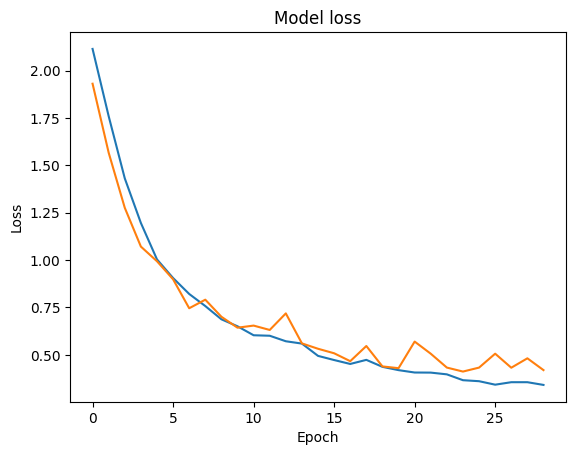

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'], label = 'train')
plt.plot(history.history['val_acc'], label = 'test')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluation of model

In [24]:
# Evaluate the model on the test set
# Subtracting 1 from y_test to align labels if they originally start from 1
test_loss, test_accuracy = model.evaluate(X_test, y_test - 1)
# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8954 - loss: 0.4258
Test Loss: 0.4195675253868103
Test Accuracy: 0.8958130478858948


In [25]:
# Generate predictions for the test set
y_predicted = model.predict(X_test)
# Use np.argmax to find the index of the maximum value in the first set of predictions,
# which corresponds to the model's predicted class label for the first image
# Pour détecter les erreur: ajouter une conditions : si
predicted_label = np.argmax(y_predicted[0])
# Convert the model's predictions from probability distributions to class labels
# by finding the index of the max probability for each prediction and adding 1
y_predicted_labels = [np.argmax(i) + 1 if max(i) > 0.7 else 0 for i in y_predicted]

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Text(95.72222222222221, 0.5, 'Truth')

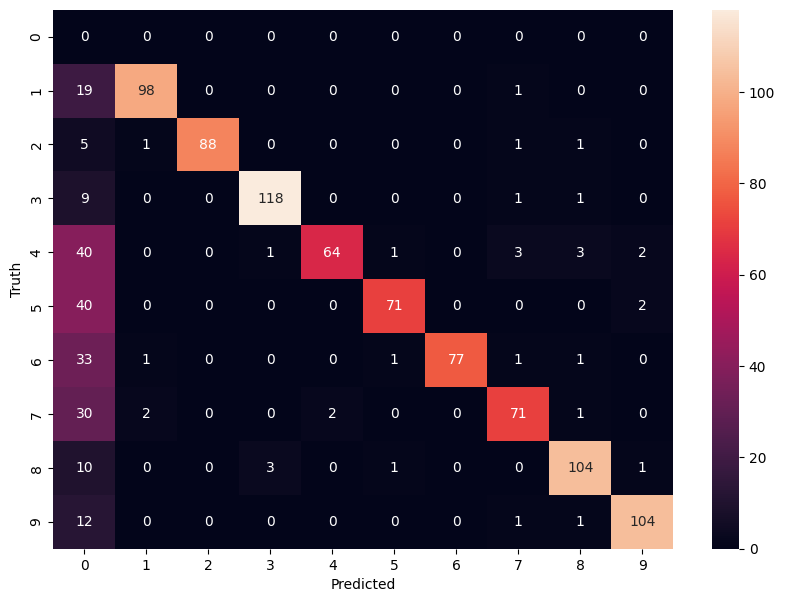

In [28]:
# Generate a confusion matrix to compare the true labels (y_test)
# against the model's predicted labels (y_predicted_labels)
cm = confusion_matrix(y_test, y_predicted_labels)
# Set the size of the figure for the heatmap
plt.figure(figsize=(10, 7))

# Create a heatmap to visualize the confusion matrix
# 'annot=True' annotates each cell with the integer value (formatted as 'd' for decimal)
# 'fmt='d'' specifies numeric formatting for annotations
sns.heatmap(cm, annot=True, fmt='d')

# Label the x-axis as "Predicted"
plt.xlabel("Predicted")

# Label the y-axis as "Truth"
plt.ylabel("Truth")

We want to minimize false positives = symbols labelled correct while they are:

* an error : FP_error

* or a different symbol : FP_symbol

It is fine to have false negative = symbols which are correct but are labelled as:

* an error : FN_error

* or a different symbol: FN_symbol

In [29]:
# Add custom metric false neg false pos
cm_np = np.array(cm)
print(cm_np)
FP_error = np.array([cm_np[0, i] for i in range(1, 9)])
FN_error = np.array([cm_np[i, 0] for i in range(1, 9)])
# /!\ delete uses the index in the np.arange(1,10) not from the cm, which is where the i-1 comes from
FP_symbol = np.array([cm_np[np.delete(np.arange(1, 9), i-1), i].sum() for i in range(1, 9)])
FN_symbol = np.array([cm_np[i, np.delete(np.arange(1, 9), i-1)].sum() for i in range(1, 9)])
print(FN_error)

[[  0   0   0   0   0   0   0   0   0   0]
 [ 19  98   0   0   0   0   0   1   0   0]
 [  5   1  88   0   0   0   0   1   1   0]
 [  9   0   0 118   0   0   0   1   1   0]
 [ 40   0   0   1  64   1   0   3   3   2]
 [ 40   0   0   0   0  71   0   0   0   2]
 [ 33   1   0   0   0   1  77   1   1   0]
 [ 30   2   0   0   2   0   0  71   1   0]
 [ 10   0   0   3   0   1   0   0 104   1]
 [ 12   0   0   0   0   0   0   1   1 104]]
[19  5  9 40 40 33 30 10]


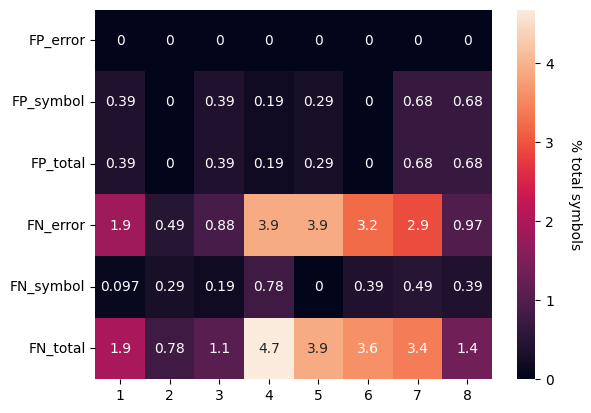

False positive : 2.629016553067186% of total symbols
False negative : 20.740019474196693% of total symbols


In [32]:
FP_total = FP_error + FP_symbol
FN_total = FN_error + FN_symbol
metrics = np.vstack((FP_error, FP_symbol, FP_total, FN_error, FN_symbol, FN_total))
# Normalize on total number of samples
metrics_n = metrics/cm_np.sum()*100
heatmap = sns.heatmap(metrics_n, annot=True)
cbar = heatmap.collections[0].colorbar
cbar.set_label('% total symbols', rotation=270, labelpad=20)
heatmap.set_xticklabels(range(1, 9))
heatmap.set_yticklabels(["FP_error", "FP_symbol", "FP_total", "FN_error", "FN_symbol", "FN_total"], rotation = 0)
plt.show()

print(f'False positive : {metrics_n.sum(axis=1)[2]}% of total symbols')
print(f'False negative : {metrics_n.sum(axis=1)[5]}% of total symbols')

# Save the model

In [31]:
# Save the model to the specified path
model.save("model/DNN_alldata_Epoch30_20240516.keras")

# Evaluate the model on the test dataset to get the loss value & metrics values for the model
test_loss, test_accuracy = model.evaluate(X_test, y_test -1)

# Print out the model's performance on the test dataset
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8954 - loss: 0.4258
Test Loss: 0.4195675253868103, Test Accuracy: 0.8958130478858948


# TODO

## Customize training :

### Custom metric: implement in model calculation
### Custom loss based on custom metric

## Implement checkpoint saving of model and stopping condition

## Try CNN